In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from PIL.ExifTags import TAGS
from statsmodels.distributions.empirical_distribution import ECDF

# April Tag Fun

In [2]:
april_tag = cv2.imread("april_tag_pure_1.png", 0)

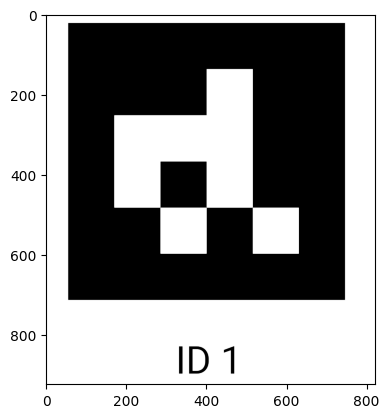

In [3]:
plt.imshow(april_tag, cmap="Greys_r")
plt.show()

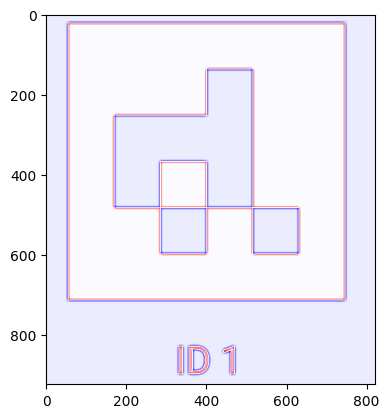

In [15]:
# Set up parameters for Guassian filter kernel matrix
stand_dev = 2 #2
half_region = int(3 * stand_dev)
full_region = (2 * half_region) + 1

# Generate a matrix of vertical cell distances relative to the kernel center
v = np.arange(-1 * half_region, half_region + 1)[::-1]
v = v.reshape(v.shape[0], 1)
v = np.repeat(v, full_region, axis=1)

# Generate a matrix of horizontal cell distances relative to the kernel center
u = -1 * v.T

# Generate a matrix of Euclidean cell distances relative to the kernel center
non_sqrt_euc = (v**2 + u**2)

def calc_LoG_kernel(non_sqrt_euc, sigma):
    """
    Generate a Laplacian of Gauassian kernel matrix using the
    Euclidean cell distances from the kernel center and a
    smoothing size measure via the Gaussian standard deviation
    """
    first_term = 1 / (np.pi * (sigma**4))
    second_term = (non_sqrt_euc / (2 * (sigma**2))) - 1
    third_term = np.exp((-1 * non_sqrt_euc) / (2 * (sigma**2)))
    return first_term * second_term * third_term

# Generate an LoG kernel matrix using the Euclidean cell distances
# and the Gaussian standard deviation
LoG_kernel = calc_LoG_kernel(non_sqrt_euc, stand_dev)

# Convolve the LoG kernel with the image matrix, with
# the image matrix values scaled to between 0 and 1
LoG_img = cv2.filter2D((april_tag / 255.0), -1, kernel=LoG_kernel)

# Display the LoG-filtered image
plt.imshow(LoG_img, cmap="bwr")
plt.show()

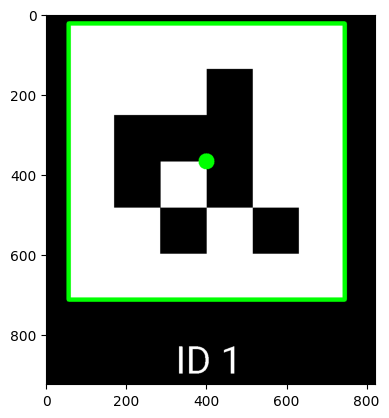

In [27]:
# Read in a fresh April Tag image and clean up to pure black & white pixel values
tag_for_thresh = cv2.imread("april_tag_pure_1.png", 0)
tag_thresh_img = (tag_for_thresh <= 50).astype(np.float32)

# Apply an opening operation to ignore the text portion of the tag
opening_kernel = np.ones((15, 15), np.uint8)
opening_tag_image = cv2.morphologyEx(tag_thresh_img, cv2.MORPH_OPEN, opening_kernel)

# Get the bounding box coordinates of the core tag
white_pixels = np.argwhere(opening_tag_image == 1)
min_v, min_u = white_pixels.min(axis=0)
max_v, max_u = white_pixels.max(axis=0)

# Get the bounding box center coordinates
mid_u = int((max_u + min_u) / 2)
mid_v = int((max_v + min_v) / 2)

# Assign the black and white color scheme to the tag image
# and generate the bounding box and center point on the image
tag_thresh_img = cv2.cvtColor(tag_thresh_img, cv2.COLOR_GRAY2RGB)
cv2.rectangle(
    tag_thresh_img,
    (min_u, min_v), (max_u, max_v),
    (0.0, 1.0, 0.0), 10
)
cv2.circle(img=tag_thresh_img, center=(mid_u, mid_v), radius=20, color=(0.0, 1.0, 0.0), thickness=-1)

# Display the tag image with the core bounding box overlayed
plt.imshow(tag_thresh_img)
plt.show()

# Live Shot Object Detection

C:\Users\jtd_2\AppData\Local\Temp\ipykernel_12500\754046173.py:5: RuntimeWarning: invalid value encountered in divide
  img_use / np.repeat(np.sum(img_use, axis=2)[:, :, np.newaxis], repeats=img_use.shape[2], axis=2),
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


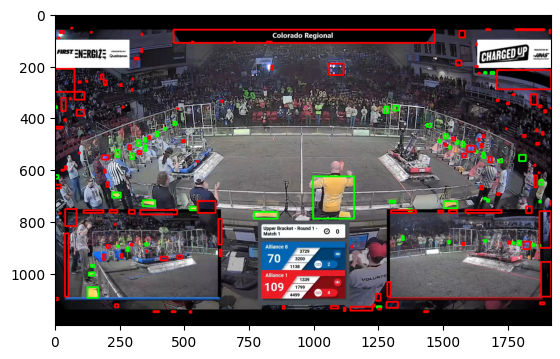

In [136]:
# Read in screenshot of live field scoring
img_use = cv2.imread("field_snap_ending.jpg")
img_use = (img_use  / 255.0)

# Extract the chromatic coordinates for the image along the RGB channels
chrom_coords = np.nan_to_num(
    img_use / np.repeat(np.sum(img_use, axis=2)[:, :, np.newaxis], repeats=img_use.shape[2], axis=2),
    0
)

# Segment cone pixels by applying binary thresholds to the chromatic coordinates
cone_seg_thresh_b = (chrom_coords[:, :, 0] < 0.3) #0.3
cone_seg_thresh_g = (chrom_coords[:, :, 1] > 0.34) #0.34
cone_seg_thresh_r = (chrom_coords[:, :, 2] > 0.35) #0.35
cone_seg_thresh = cone_seg_thresh_b & cone_seg_thresh_g & cone_seg_thresh_r

# Clean up the object pixel regions with a sequence of
# opening and closing operations
opening_kernel = np.ones((3, 3), dtype=np.uint8)
cone_seg_thresh = cv2.morphologyEx(cone_seg_thresh.astype(np.uint8), cv2.MORPH_OPEN, opening_kernel)

closing_kernel = np.ones((6, 6), dtype=np.uint8)
cone_seg_thresh = cv2.morphologyEx(cone_seg_thresh, cv2.MORPH_CLOSE, closing_kernel)

opening_kernel = np.ones((6, 6), dtype=np.uint8)
cone_seg_thresh = cv2.morphologyEx(cone_seg_thresh.astype(np.uint8), cv2.MORPH_OPEN, opening_kernel)

closing_kernel = np.ones((12, 12), dtype=np.uint8)
cone_seg_thresh = cv2.morphologyEx(cone_seg_thresh, cv2.MORPH_CLOSE, closing_kernel)

# Extract the bounding boxes from the binary cone image
cone_contours, cone_heirarchies = cv2.findContours(cone_seg_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cone_bounding_boxes = [cv2.boundingRect(cc) for cc in cone_contours]

# For each cone bounding box, overlay the box on the base image
for i in range(len(cone_contours)):
    top_left_x, top_left_y, width, height = cone_bounding_boxes[i]
    cv2.rectangle(
        img_use,
        (top_left_x, top_left_y), (top_left_x + width, top_left_y + height),
        (0, 255, 0),
        5
    )

# Segment cube pixels by applying binary thresholds to the chromatic coordinates
cube_seg_thresh_b = (chrom_coords[:, :, 0] > 0.45) #0.45
cube_seg_thresh_g = (chrom_coords[:, :, 1] < 0.27) #0.27
cube_seg_thresh_r = (chrom_coords[:, :, 2] < 0.28) #0.28
cube_seg_thresh = cube_seg_thresh_b & cube_seg_thresh_g & cube_seg_thresh_r

# Clean up the object pixel regions with an opening and closing operation
opening_kernel = np.ones((4, 4), dtype=np.uint8)
cube_seg_thresh = cv2.morphologyEx(cube_seg_thresh.astype(np.uint8), cv2.MORPH_OPEN, opening_kernel)

closing_kernel = np.ones((20, 20), dtype=np.uint8)
cube_seg_thresh = cv2.morphologyEx(cube_seg_thresh, cv2.MORPH_CLOSE, closing_kernel)

# Extract the bounding boxes from the binary cube image
cube_contours, cube_heirarchies = cv2.findContours(cube_seg_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cube_bounding_boxes = [cv2.boundingRect(cc) for cc in cube_contours]

# For each cube bounding box, overlay the box on the base image
for i in range(len(cube_contours)):
    top_left_x, top_left_y, width, height = cube_bounding_boxes[i]
    cv2.rectangle(
        img_use,
        (top_left_x, top_left_y), (top_left_x + width, top_left_y + height),
        (0, 0, 255),
        5
    )

# Display the field screenshot with the game piece bounding boxes overlayed
plt.imshow(img_use[:, :, ::-1])